In [39]:
# Import the required external module(s)
import matplotlib.pyplot as plt
import microImage as mim
import numpy as np

# Import the functions from the module
from TPHelper import startSession, startManager, intensityProfile, signalProperties, integrateProfile

## Step 0 - (Pre-step) - Opening an image using microImage
We use here the [microImage](https://github.com/vivien-walter/microImage) plug-in to open an image in an array that can be easily read by TPHelper

In [2]:
#test_file = '/path/to/folder/test_image.tif'
test_file= "/Users/vivienwalter/Documents/PROGRAMMATION/test_items/test_iscat"
imageArray = mim.openImage(test_file)

/Users/vivienwalter/Documents/PROGRAMMATION/Git/vwalter/test_tphelper/dev_tphelper/test1/lib/python3.8/site-packages/PIMS-0.4.1-py3.8.egg/pims/image_sequence.py:150: UserWarning: Loading ALL files in this directory. To ignore extraneous files, use a pattern like 'path/to/images/*.png'
  warn("Loading ALL files in this directory. To ignore extraneous "


Eventually contrast or background correct the image for better use

In [3]:
imageArray = mim.backgroundCorrection(imageArray, signed_bits=True, average='median')

In [4]:
# Crop the image to remove noisy signals on the border
imageArray = mim.cropImage(imageArray, top_left=(200,200), bottom_right=(800,800))

In [5]:
correctedArray = mim.contrastCorrection(imageArray, min=600, max=1200)

Check the image to be processed

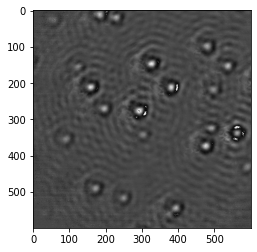

In [6]:
plt.imshow(correctedArray[0], cmap='gray')

## Step 1 - Extraction of the trajectory
We will see here how to create an instance of the class TrackingSession

### Start a session to track particles in the image sequence

In [7]:
# We load directly the array in the class to avoid calling it all the time
tpSettings = startSession(input=imageArray, diameter=41)

In [8]:
# Display all the properties
tpSettings.showParameters()

Object properties:
------------------
self.diameter: 41	self.minmass: None
self.maxsize: None	self.separation: None
self.percentile: 64	self.invert: False

Filter properties:
------------------
self.noise_size: 1	self.smoothing_size: None
self.threshold: None	self.preprocess: True
self.topn: None

Other parameters:
-----------------
self.characterize: True	self.engine: auto

Trajectory parameters:
-----------------
self.search_range: 41	self.memory: 0
self.adaptive_stop: None	self.adaptive_step: 0.95
self.neighbor_strategy: None	self.link_strategy: None
self.filter_stubs: None



### Edit some of the attributes for TrackPy

In [9]:
tpSettings.memory = 5
tpSettings.minmass = 20000
tpSettings.filter_stubs = 40
tpSettings.search_range = 101

### Process all the frames of the sequence

In [10]:
trajectory = tpSettings.batch(filter=True, store=True)

Frame 49: 22 trajectories present.


### Display the trajectory collected

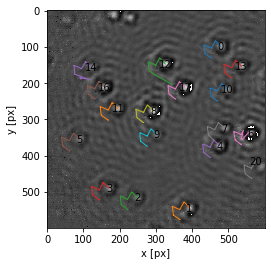

In [11]:
# We use here the contrast corrected array for the image to display
tpSettings.preview(input=correctedArray)

### Save the settings in a file

In [12]:
tpSettings.save(file_name='test_settings.json')

## Step 2 - Edit the trajectory to remove useless tracks and save it
Now that the trajectory has been extracted, we will use the class TrackManager to edit it

### Start the track manager

In [13]:
# We load directly here the contrast corrected array to make display easier
tpManager = startManager(trajectory, display_input=correctedArray)

### Display a specific track

In [14]:
# List all tracks and display the list
tpManager.listTracks()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17,
       20])

Drawing multicolor lines takes awhile. Come back in a minute.


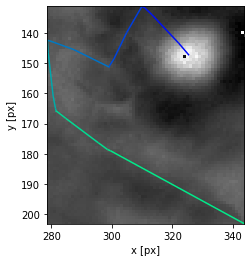

In [15]:
# Display a specific track
tpManager.show(track_ids=[12])

### Remove a track

In [16]:
# Remove the useless track
tpManager.remove(14)

In [17]:
# Reset the particle index
tpManager.resetID()
tpManager.listTracks()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

### Split a track

In [18]:
# Split the 6th track after the 11th frame 
tpManager.split(5,10)
tpManager.listTracks()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

### Merge two tracks into one

In [19]:
# Merge two tracks
tpManager.merge(5,17)

### Save the resulting trajectory into a XML file

In [20]:
# Save the trajectory in a XML file
tpManager.save(file_name='test_trajectory.xml', track_ids=None)

## Step 3 - Verify the collected tracks
Now that we have a good selection of tracks, we will check that everything is correct

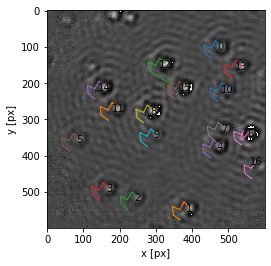

In [21]:
# Check the current tracks in the memory
tpManager.show()

/Users/vivienwalter/Documents/PROGRAMMATION/Git/vwalter/test_tphelper/dev_tphelper/test1/lib/python3.8/site-packages/scipy-1.4.1-py3.8-macosx-10.9-x86_64.egg/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


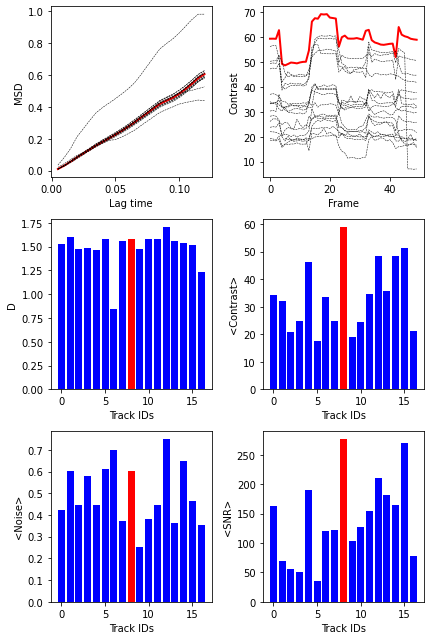

In [22]:
# Please note that the verify() command requires a lot of arguments
tpManager.verify(array=imageArray, # Use the array with the actual informations in it
                 signal_properties=True, # We want to check the contrast,noise and SNR of the objects
                 histograms = False, # We will check individual tracks mean values, and not overall distribution
                 highlight_ids = [8], # Highlight the track with the ID 8 in the results
                 fps=200, space_scale=1/46.21, # We specify the time and space scale
                )

## Step 4 - Analyze the intensity along the tracks
We will use the tracks obtained above to extract and compute the intensity of the objects

In [23]:
# Extract the selected tracks from the manager
trajectory = tpManager.extract(track_ids=[0,1,2,4,5])

In [24]:
# Calculate the intensity profiles using a sinc fit
profiles = intensityProfile(trajectory, input=imageArray, profile_type='sinc', space_scale=46.21)

/Users/vivienwalter/Documents/PROGRAMMATION/Git/vwalter/test_tphelper/dev_tphelper/test1/lib/python3.8/site-packages/scipy-1.4.1-py3.8-macosx-10.9-x86_64.egg/scipy/optimize/minpack.py:807: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


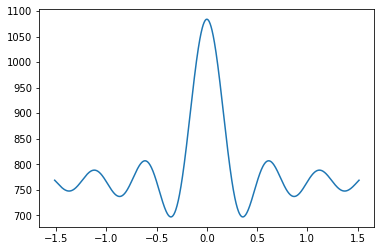

In [25]:
# Select the profile of the track with the ID = 4
track4_profile = profiles[4]

# Plot the profile of the first frame
intensity = track4_profile['intensity'][0]
distance = track4_profile['distance'][0]

plt.plot(distance, intensity)
plt.show()

In [26]:
# Extract the contrast, noise and signal-to-noise ratios from the fitted profiles
properties = signalProperties(profiles, use_fit=True)

In [27]:
# Display the mean value of the contrast of the track with the ID = 5
track5_contrasts = properties[4]['contrast']
print(track5_contrasts.mean())

39.918815201337324


In [28]:
# Calculate the integrated intensity on each raw profile
integrations = integrateProfile(profiles, use_fit=False)

In [29]:
# Display the standard deviation of the integrated intensity of the track with the ID = 0
track0_integration = integrations[0]
print(track0_integration.std())

4.689297304772174


## Step 5 - Measure the diffusivity of the particles
Since we were able to collect the tracks of the particle over time, we will now compute the MSD and the diffusitivity of the objects

In [31]:
# We extract the MSD first
msd = tpManager.getMSD(combine_all=True, fps=200, space_scale=1/46.21)

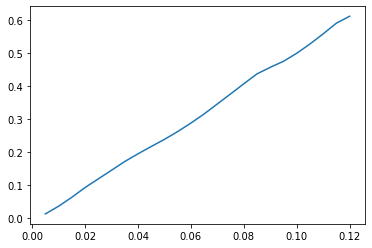

In [32]:
# Plot the MSD
plt.plot(msd[:,0], msd[:,1])

In [35]:
# Compute the diffusitivity
d_value, fit_results = tpManager.getDiffusivity(msd, dimensions=2)
display(d_value)

1.4673046848021982

{'parameters': array([5.86921874, 1.06424819]),
 'errors': array([0.14137039, 0.00986904])}

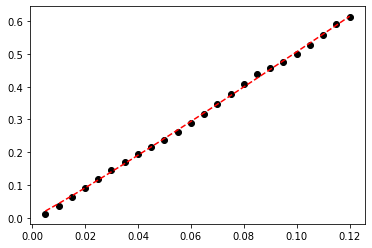

In [41]:
# Create the plot function
def powerlaw(x,a,k):
    return a*(x**k)

# Show the parameters
display(fit_results)

# Show the measurement
plt.plot(msd[:,0], msd[:,1], 'ko')

# Show the fit result
msd_range= np.arange(msd[0,0],msd[-1,0]+0.0001,.0001)
plt.plot(msd_range, powerlaw(msd_range, *fit_results['parameters']), 'r--')